# Segmented Power Law
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thodson-usgs/ratingcurve/blob/main/docs/notebooks/segmented-power-law-demo.ipynb)  

There are several approaches to fitting a stage-discharge rating curve. 
This notebook demonstrates an simple way to approximate the classic approach, 
which uses a segmented power law.

In [1]:
# Uncomment below to setup Google Colab. It will take a minute or so.
# %%capture
# !pip install pymc==5.1.2
# %env MKL_THREADING_LAYER=GNU
# !pip install git+https://github.com/thodson-usgs/ratingcurve.git

In [1]:
%load_ext autoreload
%autoreload 2

import pymc as pm
import arviz as az
from ratingcurve.ratings import PowerLawRating

## Load Data
Begin by loading the Green Channel dataset

In [2]:
from ratingcurve import data
df = data.load('green channel')
df.head()

,datetime,stage,q,q_sigma
0,2020-05-21 14:13:41 [UTC-07:00],7.04,12199.342,199.172931
1,2020-04-16 14:55:31 [UTC-07:00],4.43,4921.953,95.425619
2,2020-03-04 13:54:10 [UTC-07:00],2.99,2331.665,61.860500
3,2020-03-04 13:16:51 [UTC-07:00],2.94,2289.220,47.886745
4,2020-01-23 11:04:32 [UTC-07:00],2.96,2408.210,99.522964


and plotting the observations.

Text(0, 0.5, 'Stage (ft)')

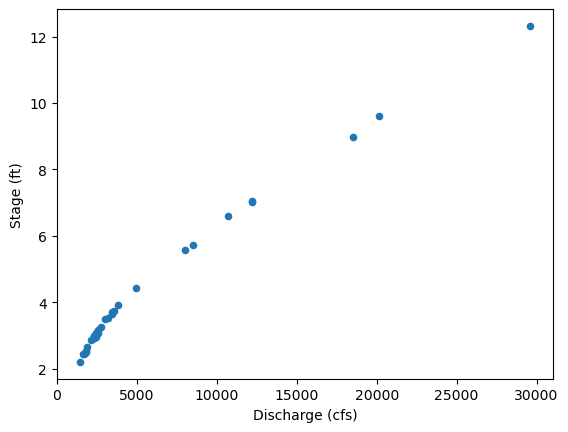

In [3]:
ax = df.plot.scatter(x='q', y='stage', marker='o')
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Stage (ft)")

## Setup model
Now, setup the rating model.
This make take a minute the first time while the model compiles but will be faster on subsequent runs.

In [4]:
powerrating = PowerLawRating(segments=2,
                             prior={'distribution':'uniform'})

There are of variety of ways to adjust the optimization.
Here we'll use the defaults,
which uses ADVI and runs for 200,000 iterations,
though the model should coverge well before that.

In [5]:
trace = powerrating.fit(q=df['q'],
                        h=df['stage'], 
                        q_sigma=df['q_sigma'])

Convergence achieved at 173000
Interrupted at 172,999 [86%]: Average Loss = -10.281
Sampling: [a, b, hs_, model_q, sigma]
Sampling: [model_q]


Once fit, we can plot the rating curve.

Sampling: [model_q]


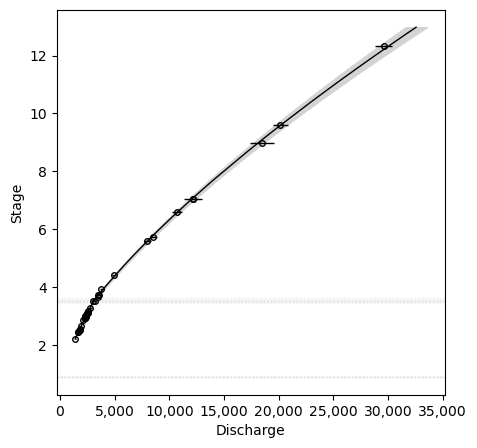

In [7]:
powerrating.plot()

or as a table of stage-discharge values.

In [8]:
table = powerrating.table()
table.head()

Sampling: [model_q]


,stage,discharge,median,gse
0,2.21,1386.599886,1386.539950,1.010694
1,2.22,1398.845341,1398.717120,1.010624
2,2.23,1410.981904,1411.059618,1.010537
3,2.24,1423.196686,1422.953091,1.010580
4,2.25,1435.474726,1435.369685,1.010498


## Exercise
What happens if we choose the wrong number of segments? 
Increase the number of segments by one and rerun the model.
In fact, we can use this to select the correct number of segments,
which is demonstrated in the [model evaluation notebook](https://github.com/thodson-usgs/ratingcurve/blob/main/docs/notebooks/model-selection-tutorial.ipynb).

## Simulated Example
This example uses a simulated rating curve, which allows you to test how changing the number of segments affects the rating curve.

First, load the '3-segment simulated' tutorial dataset.

In [10]:
sim_df = data.load('3-segment simulated')

This rating contains observations of every 0.01 inch. increment in stage, which is much more than we'd have for a natural rating.
Try sampling to `n_sample=15` or `n_sample=30` and see how that affects the model fit.

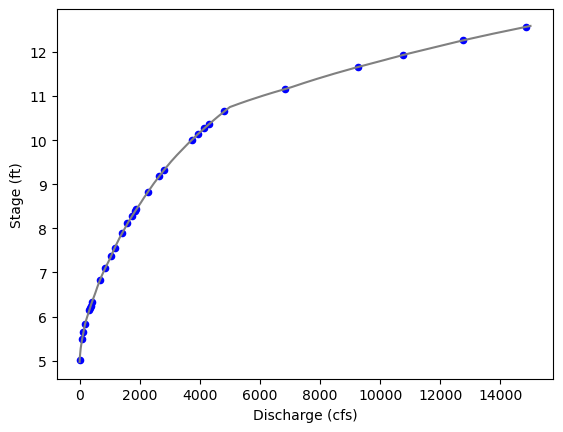

In [11]:
# subsample the simulated rating curve
n_sample = 30
df = sim_df.sample(n_sample, random_state=12345)

ax = sim_df.plot(x='q', y='stage', color='grey', ls='-', legend=False)
df.plot.scatter(x='q', y='stage', marker='o', color='blue', ax=ax)
ax.set_xlabel("Discharge (cfs)");
ax.set_ylabel("Stage (ft)");

Setup a rating model with 3 segments

In [12]:
powerrating = PowerLawRating(segments=3,
                             prior={'distribution':'uniform'},
                             #prior={'distribution':'normal', 'mu':[5, 8, 11], 'sigma':[1, 1, 0.2]}
                            )

now fit the model using ADVI

In [13]:
trace = powerrating.fit(q=df['q'],
                        h=df['stage'],
                        q_sigma=None,
                        method='advi')

Finished [100%]: Average Loss = -57.395
Sampling: [a, b, hs_, model_q, sigma]
Sampling: [model_q]


and visualize the results.

Sampling: [model_q]


<Axes: xlabel='q', ylabel='Stage'>

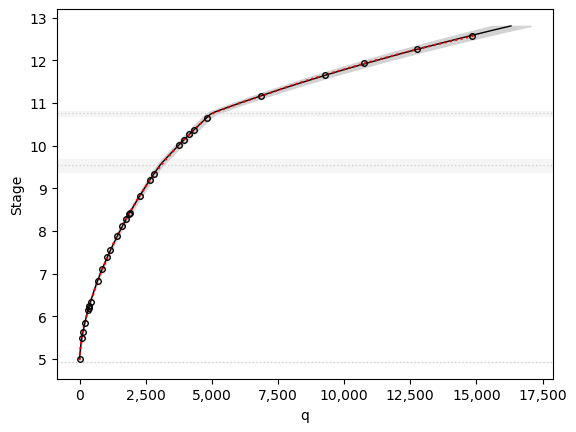

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
powerrating.plot(ax=ax)

# plot the original data for comparison
sim_df.plot(x='q', y='stage', color='red', ls=':', legend=False, ax=ax)

In [15]:
powerrating.summary(var_names=["b", "a", "sigma", "hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[0],0.969,0.001,0.966,0.971,0.000,0.000,9359.0,9380.0,NaN
b[1],0.074,0.003,0.069,0.080,0.000,0.000,10158.0,9838.0,NaN
b[2],0.307,0.005,0.297,0.317,0.000,0.000,9768.0,9414.0,NaN
a,-0.999,0.002,-1.002,-0.996,0.000,0.000,9698.0,9490.0,NaN
sigma,0.010,0.001,0.007,0.012,0.000,0.000,9858.0,9455.0,NaN
"hs[0, 0]",4.932,0.001,4.931,4.933,0.000,0.000,10069.0,9800.0,NaN
"hs[1, 0]",9.540,0.084,9.387,9.701,0.001,0.001,9860.0,9764.0,NaN
"hs[2, 0]",10.761,0.027,10.711,10.813,0.000,0.000,9925.0,9086.0,NaN


Fitting this model can be tricky.
The most common issue is a poor initialization of the breakpoints.
A fix is under development, but for now, try
1. reinitializing the model `PowerLawRating()`;
1. increasing the number of iterations for the fitting algorithm `fit(n=300_000)`;
1. a prior on the breakpoints, example, try `prior={'distribution':'normal', 'mu':[5, 9.5, 10.5], 'sigma':[1, 1, 0.2]})`, which implies we know the true breakpoint within +-0.5 ft; or
1. fitting the model with NUTS `fit(method='nuts')`.

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray